In [1]:
import numpy as np
import pandas as pd
import time
#import fma
import os
#import librosa
import scipy
import tensorflow as tf
#from tqdm import tqdm
import multiprocessing
from sklearn.utils import shuffle
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder

import keras
from keras.models import Sequential
from keras.models import Model, load_model
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Input, Embedding, LSTM, GRU
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Bidirectional, Lambda
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras import backend as K
from keras.utils import to_categorical

from sklearn.utils import shuffle
#from sklearn.preprocessing import normalize

import argparse

#tf.enable_eager_execution()

Using TensorFlow backend.


In [2]:
# convert class to ohe 

def ohe(label):
    if label == 0: # dark
        return np.array([1., 0., 0., 0., 0.])
    elif label == 1: # downtempo
        return np.array([0., 1., 0., 0., 0.])
    elif label == 2: # fullon
        return np.array([0., 0., 1., 0., 0.])
    elif label == 3: # goa
        return np.array([0., 0., 0., 1., 0.])
    elif label == 4: # techno
        return np.array([0., 0., 0., 0., 1.])

In [3]:
# convert from ohe back to classe
def eho(label):
    
    if np.array_equal(np.asarray(label), np.array([1., 0., 0., 0., 0.])):
        return 'dark'
    
    if np.array_equal(np.asarray(label), np.array([0., 1., 0., 0., 0.])):
        return 'downtempo'

    if np.array_equal(np.asarray(label), np.array([0., 0., 1., 0., 0.])):
        return 'fullon'

    if np.array_equal(np.asarray(label), np.array([0., 0., 0., 1., 0.])):
        return 'goa'

    if np.array_equal(np.asarray(label), np.array([0., 0., 0., 0., 1.])):
        return 'techno'

In [4]:
# read the best model

smodel = tf.keras.models.load_model('best_psy_cnn.h5')

In [5]:
from os import listdir
from os.path import isfile, join

# find all pkl files for prediction testing
# pkl files contain 30 spectrogram slices (as np arrays) from the midpoints of novel songs

mypath = '../test_data/pkls/'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

In [6]:
# translate prediction results to actual string label

def translate(results):
    genres = [eho(x) for x in results]
    return genres

In [7]:
# produce aggregate metrics of accuracy for predictions of 30 spectrograms of a song

def agg_predict(results):
    genres = translate(results)
    uniqs = np.unique(genres)
    
    from collections import Counter

    c = Counter([i for i in genres])
    
#     for u in uniqs:
#         print(u + ' ' + str(c[u]))
        
    predict = np.max([c])
    return (c.most_common(1)[0])
        
def predict_spectrograms(sample):
    
    y_prob = smodel.predict(sample.reshape(30,128,128,1))
    y_classes = y_prob.argmax(axis=-1)
    t = tf.one_hot(tf.argmax(y_prob, axis = 1), depth = 5)
    
    with tf.Session() as sess:
        res = sess.run(t)
        
    return agg_predict(res)
    

In [8]:
import random
randomnum = random.randint(0, len(onlyfiles))
fn = onlyfiles[randomnum]
sample = np.load(mypath+ onlyfiles[randomnum])

print(fn + '\n')

predict_spectrograms(sample)

goa_8.pkl



('goa', 30)

In [9]:
hits = 0
misses = 0

verify = []

for f in onlyfiles:
    label = f.split('_',1)[0]
    print('-'*28)
    print(f.split('_',1)[0] + str(' song'))
    print('-'*28)
    sample = np.load(mypath+ f)
    predict = predict_spectrograms(sample)
    if label == predict[0]:
        print('hit')
        hits+=1
    else:
        print('thought it was actually:')
        print(predict[0])
        misses+=1
        verify.append(f)

acc = hits / (hits+misses)
print(acc)

----------------------------
goa song
----------------------------
thought it was actually:
downtempo
----------------------------
downtempo song
----------------------------
hit
----------------------------
techno song
----------------------------
hit
----------------------------
techno song
----------------------------
thought it was actually:
downtempo
----------------------------
downtempo song
----------------------------
hit
----------------------------
dark song
----------------------------
thought it was actually:
downtempo
----------------------------
fullon song
----------------------------
thought it was actually:
goa
----------------------------
downtempo song
----------------------------
hit
----------------------------
goa song
----------------------------
hit
----------------------------
goa song
----------------------------
hit
----------------------------
fullon song
----------------------------
hit
----------------------------
dark song
----------------------------
th

In [54]:
# a correctly classified goa track
sample = np.load(mypath + onlyfiles[8])

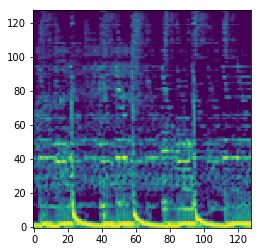

In [55]:
plt.imshow(sample[10], origin = 'lower')
plt.show()
plt.imsave('correct_goa.pdf', sample[10], dpi = 600, origin = 'lower')

In [56]:
# a misclassified goa track
sample = np.load(mypath+ verify[0])

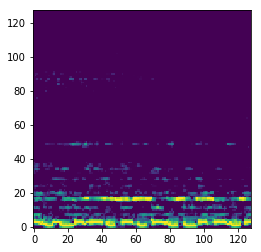

In [57]:
plt.imshow(sample[10], origin = 'lower')
plt.show()
plt.imsave('incorrect_goa.pdf', sample[10], dpi = 600, origin = 'lower')